# Zero-Shot Classification using CLAP Models

Embeddings used in these experiments are extracted in the extract_embeddings.ipynb notebook. Each experiment is executed on MSCLAP and LAION CLAP.

Experiments:
1. k-fold evaluation. Accuracy and average precision is reported. The results for each fold are averaged over 1k calculations. The experiment is repeated with and without overlapping samples between folds, comprising 200 and 17 folds respectively. 
2. Based on the inspection of probabilities and top 3 class choices, classification errors are plausible errors for human labelers to make. Misclassified audio files are replaced by the 2nd and 3rd choice, in addition to a cascading version where errors after 2nd-choice substitution are replaced by the 3rd choice.

In [7]:
from msclap import CLAP
import laion_clap
import json
import pandas as pd
import numpy as np
from utils.dataset import DatasetUCS
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import configs.graphics_settings as graphics_settings
import random
import IPython.display as ipd
import librosa
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from utils.experiment_logger import ExperimentLogger
from utils.set_torch_device import set_torch_device
from utils.seed_everything import seed_everything
from utils.evaluation_utils import k_fold_zs_predict, k_fold_zs_evaluation, load_embeddings_from_disk

In [2]:
# Load Testing Set
with open ('configs/kfold17-zero_shot.json', 'r') as f:
    settings_kfold17 = json.load (f)

with open ('configs/kfold200-zero_shot.json', 'r') as f:
    settings_kfold200 = json.load (f)

device, _ = set_torch_device()

In [3]:
# Load models
msclap_model = CLAP(version = '2023', use_cuda=True) # version can be 2022 or 2023
laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
laion_clap_model.load_ckpt()

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.we

In [4]:
k_fold_200_audio_embeddings_laion = load_embeddings_from_disk(settings_kfold200["laion_audio_embeddings"])
k_fold_200_audio_embeddings_msclap = load_embeddings_from_disk(settings_kfold200["msclap_audio_embeddings"])
k_fold_17_audio_embeddings_laion = load_embeddings_from_disk(settings_kfold17["laion_audio_embeddings"]) 
k_fold_17_audio_embeddings_msclap = load_embeddings_from_disk(settings_kfold17["msclap_audio_embeddings"])

## Single Example Evaluation

This block outlines the process used to make a single prediction and inspect probabilities. This can be used to manually inspect classifications. Ignore this block if you only have access to embeddings, as it will look for the audio files.

                                                 path  channels  samples  \
45  E:/Soundly Library juni 2023/Soundly Pro/Liqui...         2    29397   

    sample_rate  bit_depth      category sub_category  
45        96000         24  liquid & mud       impact  
Predicted Class (Best Prediction): liquid & mud at UCS index 46
Predicted Classes (Best Match To Worst): liquid & mud, water, dirt & sand
True Class: liquid & mud at UCS index 46
Predicted Class (Best Prediction): rubber at UCS index 62
Predicted Classes (Best Match To Worst): rubber, liquid & mud, gore
True Class: liquid & mud at UCS index 46


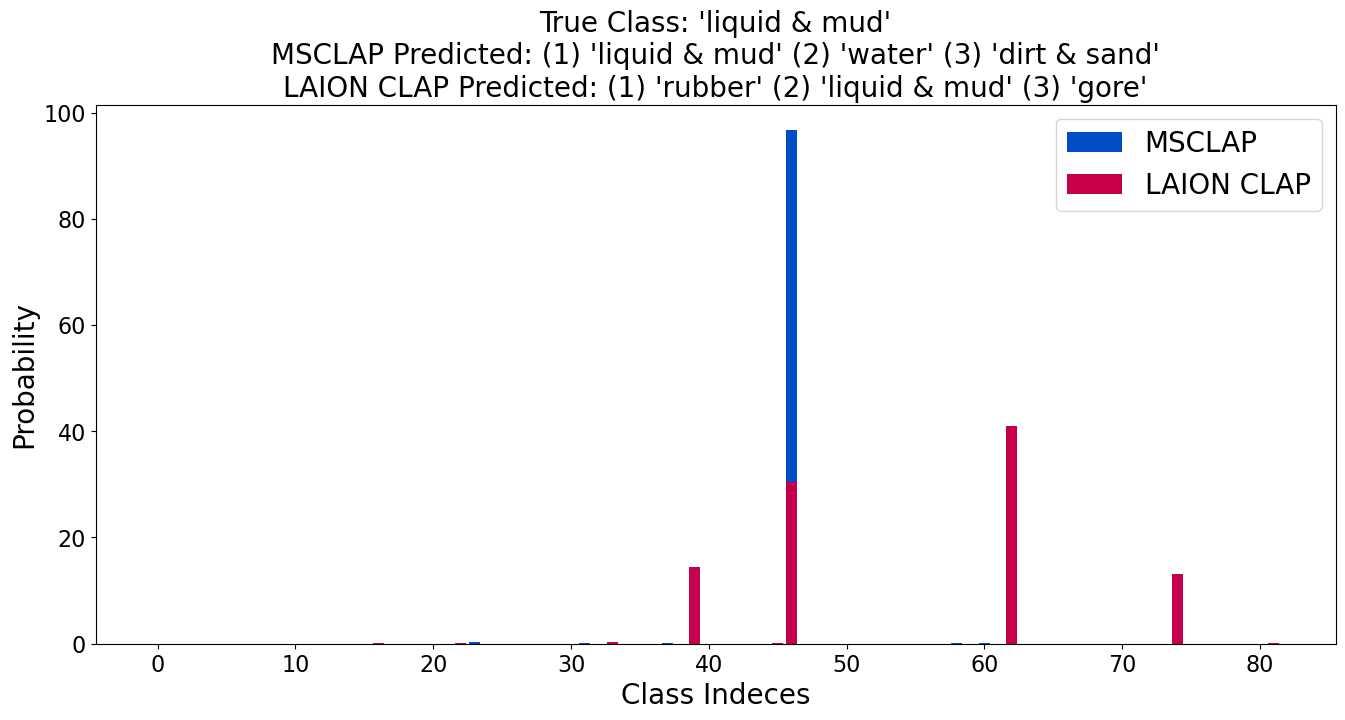

In [25]:
with open (settings_kfold200['class_converter'], 'r') as f:
    ucs_classes = json.load (f)

# Make a copy to avoid issues with concatenations later.
ms_k_fold_embeddings = k_fold_17_audio_embeddings_msclap
laion_k_fold_embeddings = k_fold_17_audio_embeddings_laion
category_to_test = 'liquid & mud'

# Sample randomly from the dataset.
fold_idx = random.randint(0, ms_k_fold_embeddings.size()[0]-1)
#sample_idx = random.randint(0, k_fold_embeddings.size()[1]-1) # Random sample

# Load data from a random fold
df = pd.read_csv(settings_kfold17["ground_truth"] + f"zs_fold_{fold_idx+1}.csv") # not 0-indexed

print(f"{df[df['category'] == category_to_test]}") # Get sample from smallest class.
sample_idx = df.index[df['category'] == category_to_test].tolist()[0] # Get specific sample from random fold
dataset = DatasetUCS(df, settings_kfold200, device=device, return_type='path')
path, _, class_name = dataset[sample_idx]

# Get embeddings
label_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))
ms_current_emb = ms_k_fold_embeddings[fold_idx][sample_idx]
laion_current_emb = laion_k_fold_embeddings[fold_idx][sample_idx]

# Compute probabilities and plot
fig = plt.figure(2, figsize=(16, 7))
ax = fig.subplots(1)
title = f"True Class: '{class_name}'"
for name, current_emb in zip(["MSCLAP", "LAION CLAP"],[ms_current_emb, laion_current_emb]):

    if (name == "MSCLAP"):
        label_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))
        color = graphics_settings.primary_color
    else:
        label_embeddings = laion_clap_model.get_text_embedding(list(ucs_classes['class_to_int'].keys()))
        color = graphics_settings.secondary_color

    similarities = msclap_model.compute_similarity(current_emb, torch.Tensor(label_embeddings).to(device))
    similarities = similarities.detach()
    probs = torch.softmax(similarities.view(1, -1), dim=1).detach().flatten() * 100
    probs = probs.cpu()
    pred_labels = torch.topk(probs, k=3).indices

    # Convert int indeces to strings
    str_labels = []
    for label in pred_labels:
        str_labels.append(f"{label}")

    # Print Results
    idx = torch.argmax(probs)
    idx = f"{idx}"
    print(f"Predicted Class (Best Prediction): {ucs_classes['int_to_class'][idx]} at UCS index {idx}")
    print(f"Predicted Classes (Best Match To Worst): {ucs_classes['int_to_class'][str_labels[0]]}, {ucs_classes['int_to_class'][str_labels[1]]}, {ucs_classes['int_to_class'][str_labels[2]]}")
    print(f"True Class: {class_name} at UCS index {ucs_classes['class_to_int'][class_name]}")

    # Plot probabilities

    ax.set_ylabel("Probability", fontsize=20)
    ax.set_xlabel("Class Indeces", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    title = title + f"\n{name} Predicted: (1) '{ucs_classes['int_to_class'][str_labels[0]]}' (2) '{ucs_classes['int_to_class'][str_labels[1]]}' (3) '{ucs_classes['int_to_class'][str_labels[2]]}'"

    #ax.set_ylim(0, 100)
    ax.bar(range(len(probs)), height=probs, color=color, label=name)

ax.legend(fontsize=20)
ax.set_title(title, fontsize=20)

ipd.Audio(path)

# K-Fold Zero Shot Classification



In [28]:
seed_everything(1337)
experiment_logger = ExperimentLogger("logs/", "unnamed_experiment")

unnamed_experiment


In [36]:
msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels = k_fold_zs_predict(settings_kfold17, k_fold_17_audio_embeddings_msclap, msclap_model.get_text_embeddings, msclap_model.compute_similarity, device=device)
msclap_k_fold_17_accuracy, msclap_k_fold_17_precision, msclap_k_fold_17_recall, msclap_k_fold_17_f1, msclap_k_fold_17_ap = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_17_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_17_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_17_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_17_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_17_f1}")

laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels = k_fold_zs_predict(settings_kfold17, k_fold_17_audio_embeddings_laion, laion_clap_model.get_text_embedding, torch.cosine_similarity, device=device)
laion_k_fold_17_accuracy, laion_k_fold_17_precision, laion_k_fold_17_recall, laion_k_fold_17_f1, laion_k_fold_17_ap = k_fold_zs_evaluation(laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_17_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_17_ap}")
print(f"LAION Precision Score: {laion_k_fold_17_precision}")
print(f"LAION Recall Score: {laion_k_fold_17_recall}")
print(f"LAION F1 Score: {laion_k_fold_17_f1}")

experiment_logger.experiment_name = "kfold17-zero_shot"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_17_accuracy,
        "average_precision" : msclap_k_fold_17_ap,
        "recall" : msclap_k_fold_17_recall,
        "precision" : msclap_k_fold_17_precision,
        "f1" : msclap_k_fold_17_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_17_accuracy,
        "average_precision" : laion_k_fold_17_ap,
        "recall" : laion_k_fold_17_recall,
        "precision" : laion_k_fold_17_precision,
        "f1" : laion_k_fold_17_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


MSCLAP Accuracy Score: 0.25199709513435004
MSCLAP Average Precision Score: 0.012177299627363396
MSCLAP Precision Score: 0.2554558114081962
MSCLAP Recall Score: 0.25199709513435004
MSCLAP F1 Score: 0.21977154613436553


100%|██████████| 17/17 [00:04<00:00,  4.05it/s]

LAION Accuracy Score: 0.21931735657225854
LAION Average Precision Score: 0.011412813390354687
LAION Precision Score: 0.22545928329332274
LAION Recall Score: 0.21664275466284072
LAION F1 Score: 0.19055179141529677


In [8]:
msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(settings_kfold200, k_fold_200_audio_embeddings_msclap, msclap_model.get_text_embeddings, msclap_model.compute_similarity, device=device)
msclap_k_fold_200_accuracy, msclap_k_fold_200_precision, msclap_k_fold_200_recall, msclap_k_fold_200_f1, msclap_k_fold_200_ap = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_200_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_200_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_200_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_200_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_200_f1}")

laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(settings_kfold200, k_fold_200_audio_embeddings_laion, laion_clap_model.get_text_embedding, torch.cosine_similarity, device=device)
laion_k_fold_200_accuracy, laion_k_fold_200_precision, laion_k_fold_200_recall, laion_k_fold_200_f1, laion_k_fold_200_ap = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_200_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_200_ap}")
print(f"LAION Precision Score: {laion_k_fold_200_precision}")
print(f"LAION Recall Score: {laion_k_fold_200_recall}")
print(f"LAION F1 Score: {laion_k_fold_200_f1}")

experiment_logger.experiment_name = "kfold200-zero_shot"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_200_accuracy,
        "average_precision" : msclap_k_fold_200_ap,
        "recall" : msclap_k_fold_200_recall,
        "precision" : msclap_k_fold_200_precision,
        "f1" : msclap_k_fold_200_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_200_accuracy,
        "average_precision" : laion_k_fold_200_ap,
        "recall" : laion_k_fold_200_recall,
        "precision" : laion_k_fold_200_precision,
        "f1" : laion_k_fold_200_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


MSCLAP Accuracy Score: 0.26654320987654323
MSCLAP Average Precision Score: 0.01472771779410438
MSCLAP Precision Score: 0.3107401820657017
MSCLAP Recall Score: 0.26654320987654323
MSCLAP F1 Score: 0.23735447066717857


100%|██████████| 200/200 [00:48<00:00,  4.16it/s]

LAION Accuracy Score: 0.23104938271604938
LAION Average Precision Score: 0.01025830237141868
LAION Precision Score: 0.24843351111542056
LAION Recall Score: 0.22823170731707318
LAION F1 Score: 0.20479072247756694


## Class-Merged kfold200 (Explained Accuracy)
MSCLAP is pretty consistent regarding the classes it confuses, while LAION CLAP is more diffuse. Because MSCLAP also got a better accuracy score, this next section will report the change in accuracy when wrong predictions are replaced by the topk result, where k=2 or 3.

In [30]:
settings = settings_kfold200 # settings_kfold17 or settings_kfold200
embs_audio = k_fold_200_audio_embeddings_msclap # k_fold_17_audio_embeddings_msclap or k_fold_200_audio_embeddings_msclap

msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(
    settings, 
    embs_audio, 
    msclap_model.get_text_embeddings, 
    msclap_model.compute_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in msclap_k_fold_200_pred_labels] # 1st Prediction
k_2 = [row[1] for row in msclap_k_fold_200_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in msclap_k_fold_200_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
msclap_k_fold_200_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(msclap_k_fold_200_gold_labels, k_1, k_2)]
msclap_k_fold_200_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(msclap_k_fold_200_gold_labels, k_1, k_3)]
# Cascading version
msclap_k_fold_200_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk2replaced, k_3)]

# Evaluate
msclap_kfold200_accuracy_k2, msclap_kfold200_precision_k2, msclap_kfold200_recall_k2, msclap_kfold200_f1_k2, msclap_kfold200_ap_k2 = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk2replaced)

print(f"MSCLAP Accuracy Score (Topk=2): {msclap_kfold200_accuracy_k2}")
print(f"MSCLAP Average Precision Score (Topk=2): {msclap_kfold200_ap_k2}")
print(f"MSCLAP Precision Score (Topk=2): {msclap_kfold200_precision_k2}")
print(f"MSCLAP Recall Score (Topk=2): {msclap_kfold200_recall_k2}")
print(f"MSCLAP F1 Score (Topk=2): {msclap_kfold200_f1_k2}")
print("\n")
msclap_kfold200_accuracy_k3, msclap_kfold200_precision_k3, msclap_kfold200_recall_k3, msclap_kfold200_f1_k3, msclap_kfold200_ap_k3 = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk3replaced)

print(f"MSCLAP Accuracy Score (Topk=3): {msclap_kfold200_accuracy_k3}")
print(f"MSCLAP Average Precision Score (Topk=3): {msclap_kfold200_ap_k3}")
print(f"MSCLAP Precision Score (Topk=3): {msclap_kfold200_precision_k3}")
print(f"MSCLAP Recall Score (Topk=3): {msclap_kfold200_recall_k3}")
print(f"MSCLAP F1 Score (Topk=3): {msclap_kfold200_f1_k3}")
print("\n")
msclap_kfold200_accuracy_cascade, msclap_kfold200_precision_cascade, msclap_kfold200_recall_cascade, msclap_kfold200_f1_cascade, msclap_kfold200_ap_cascade = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk_cascade)

print(f"MSCLAP Accuracy Score (Topk=2+3): {msclap_kfold200_accuracy_cascade}")
print(f"MSCLAP Average Precision Score (Topk=2+3): {msclap_kfold200_ap_cascade}")
print(f"MSCLAP Precision Score (Topk=2+3): {msclap_kfold200_precision_cascade}")
print(f"MSCLAP Recall Score (Topk=2+3): {msclap_kfold200_recall_cascade}")
print(f"MSCLAP F1 Score (Topk=2+3): {msclap_kfold200_f1_cascade}")

100%|██████████| 17/17 [00:05<00:00,  3.19it/s]

MSCLAP Accuracy Score (Topk=2): 0.36020334059549747
MSCLAP Average Precision Score (Topk=2): 0.023266872715705423
MSCLAP Precision Score (Topk=2): 0.3464800207311418
MSCLAP Recall Score (Topk=2): 0.3602033405954974
MSCLAP F1 Score (Topk=2): 0.3260359363834089


MSCLAP Accuracy Score (Topk=3): 0.3289760348583878
MSCLAP Average Precision Score (Topk=3): 0.022870377696160023
MSCLAP Precision Score (Topk=3): 0.3399327276639201
MSCLAP Recall Score (Topk=3): 0.32897603485838783
MSCLAP F1 Score (Topk=3): 0.30368962925162774


MSCLAP Accuracy Score (Topk=2+3): 0.4371822803195352
MSCLAP Average Precision Score (Topk=2+3): 0.022677281493104377
MSCLAP Precision Score (Topk=2+3): 0.4231959180921179
MSCLAP Recall Score (Topk=2+3): 0.43718228031953515
MSCLAP F1 Score (Topk=2+3): 0.39753408404895807


In [31]:
settings = settings_kfold200 # settings_kfold17 or settings_kfold200
embs_audio = k_fold_200_audio_embeddings_laion # k_fold_17_audio_embeddings_laion or k_fold_200_audio_embeddings_laion

laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(
    settings,
    embs_audio, 
    laion_clap_model.get_text_embedding, 
    torch.cosine_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in laion_k_fold_200_pred_labels] # 1st Prediction
k_2 = [row[1] for row in laion_k_fold_200_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in laion_k_fold_200_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
laion_k_fold_200_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(laion_k_fold_200_gold_labels, k_1, k_2)]
laion_k_fold_200_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(laion_k_fold_200_gold_labels, k_1, k_3)]
# Cascading version
laion_k_fold_200_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk2replaced, k_3)]

# Evaluate
laion_kfold200_accuracy_k2, laion_kfold200_precision_k2, laion_kfold200_recall_k2, laion_kfold200_f1_k2, laion_kfold200_ap_k2 = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk2replaced)

print(f"LAION CLAP Accuracy Score (Topk=2): {laion_kfold200_accuracy_k2}")
print(f"LAION CLAP Average Precision Score (Topk=2): {laion_kfold200_ap_k2}")
print(f"LAION CLAP Precision Score (Topk=2): {laion_kfold200_precision_k2}")
print(f"LAION CLAP Recall Score (Topk=2): {laion_kfold200_recall_k2}")
print(f"LAION CLAP F1 Score (Topk=2): {laion_kfold200_f1_k2}")
print("\n")
laion_kfold200_accuracy_k3, laion_kfold200_precision_k3, laion_kfold200_recall_k3, laion_kfold200_f1_k3, laion_kfold200_ap_k3 = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk3replaced)

print(f"LAION CLAP Accuracy Score (Topk=3): {laion_kfold200_accuracy_k3}")
print(f"LAION CLAP Average Precision Score (Topk=3): {laion_kfold200_ap_k3}")
print(f"LAION CLAP Precision Score (Topk=3): {laion_kfold200_precision_k3}")
print(f"LAION CLAP Recall Score (Topk=3): {laion_kfold200_recall_k3}")
print(f"LAION CLAP F1 Score (Topk=3): {laion_kfold200_f1_k3}")
print("\n")
laion_kfold200_accuracy_cascade, laion_kfold200_precision_cascade, laion_kfold200_recall_cascade, laion_kfold200_f1_cascade, laion_kfold200_ap_cascade = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk_cascade)

print(f"LAION CLAP Accuracy Score (Topk=2+3): {laion_kfold200_accuracy_cascade}")
print(f"LAION CLAP Average Precision Score (Topk=2+3): {laion_kfold200_ap_cascade}")
print(f"LAION CLAP Precision Score (Topk=2+3): {laion_kfold200_precision_cascade}")
print(f"LAION CLAP Recall Score (Topk=2+3): {laion_kfold200_recall_cascade}")
print(f"LAION CLAP F1 Score (Topk=2+3): {laion_kfold200_f1_cascade}")

100%|██████████| 17/17 [00:04<00:00,  3.82it/s]

LAION CLAP Accuracy Score (Topk=2): 0.32171387073347857
LAION CLAP Average Precision Score (Topk=2): 0.01107408624028061
LAION CLAP Precision Score (Topk=2): 0.31397288220228387
LAION CLAP Recall Score (Topk=2): 0.3177905308464849
LAION CLAP F1 Score (Topk=2): 0.2908114617473655


LAION CLAP Accuracy Score (Topk=3): 0.28685548293391433
LAION CLAP Average Precision Score (Topk=3): 0.011197076278320318
LAION CLAP Precision Score (Topk=3): 0.30491054887887753
LAION CLAP Recall Score (Topk=3): 0.2833572453371592
LAION CLAP F1 Score (Topk=3): 0.2655490840150719


LAION CLAP Accuracy Score (Topk=2+3): 0.38925199709513436
LAION CLAP Average Precision Score (Topk=2+3): 0.011197173620748558
LAION CLAP Precision Score (Topk=2+3): 0.3844450236764869
LAION CLAP Recall Score (Topk=2+3): 0.3845050215208034
LAION CLAP F1 Score (Topk=2+3): 0.3557153109851266


In [10]:
# Log Results
experiment_logger.experiment_name = "kfold200-zero_shot-topk"
results = {
    "msclap" : {
        "topk1" : {
            "accuracy" : msclap_k_fold_200_accuracy,
            "average_precision" : msclap_k_fold_200_ap,
            "recall" : msclap_k_fold_200_recall,
            "precision" : msclap_k_fold_200_precision,
            "f1" : msclap_k_fold_200_f1
        },
        "topk2" : {
            "accuracy" : msclap_kfold200_accuracy_k2,
            "average_precision" : msclap_kfold200_ap_k2,
            "recall" : msclap_kfold200_recall_k2,
            "precision" : msclap_kfold200_precision_k2,
            "f1" : msclap_kfold200_f1_k2
        },
        "topk3" : {
            "accuracy" : msclap_kfold200_accuracy_k3,
            "average_precision" : msclap_kfold200_ap_k3,
            "recall" : msclap_kfold200_recall_k3,
            "precision" : msclap_kfold200_precision_k3,
            "f1" : msclap_kfold200_f1_k3
        },
        "cascade" : {
            "accuracy" : msclap_kfold200_accuracy_cascade,
            "average_precision" : msclap_kfold200_ap_cascade,
            "recall" : msclap_kfold200_recall_cascade,
            "precision" : msclap_kfold200_precision_cascade,
            "f1" : msclap_kfold200_f1_cascade
        },
    },
    "laion" : {
        "topk1" : {
            "accuracy" : laion_k_fold_200_accuracy,
            "average_precision" : laion_k_fold_200_ap,
            "recall" : laion_k_fold_200_recall,
            "precision" : laion_k_fold_200_precision,
            "f1" : laion_k_fold_200_f1
        },
        "topk2" : {
            "accuracy" : laion_kfold200_accuracy_k2,
            "average_precision" : laion_kfold200_ap_k2,
            "recall" : laion_kfold200_recall_k2,
            "precision" : laion_kfold200_precision_k2,
            "f1" : laion_kfold200_f1_k2
        },
        "topk3" : {
            "accuracy" : laion_kfold200_accuracy_k3,
            "average_precision" : laion_kfold200_ap_k3,
            "recall" : laion_kfold200_recall_k3,
            "precision" : laion_kfold200_precision_k3,
            "f1" : laion_kfold200_f1_k3
        },
        "cascade" : {
            "accuracy" : laion_kfold200_accuracy_cascade,
            "average_precision" : laion_kfold200_ap_cascade,
            "recall" : laion_kfold200_recall_cascade,
            "precision" : laion_kfold200_precision_cascade,
            "f1" : laion_kfold200_f1_cascade
        }
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

In [32]:
# Prepare top predictions for plotting. Unpack.
laion_k_fold_200_pred_labels_topk1 = [row[0] for row in laion_k_fold_200_pred_labels] # 1st Prediction
msclap_k_fold_200_pred_labels_topk1 = [row[0] for row in msclap_k_fold_200_pred_labels] # 1st Prediction

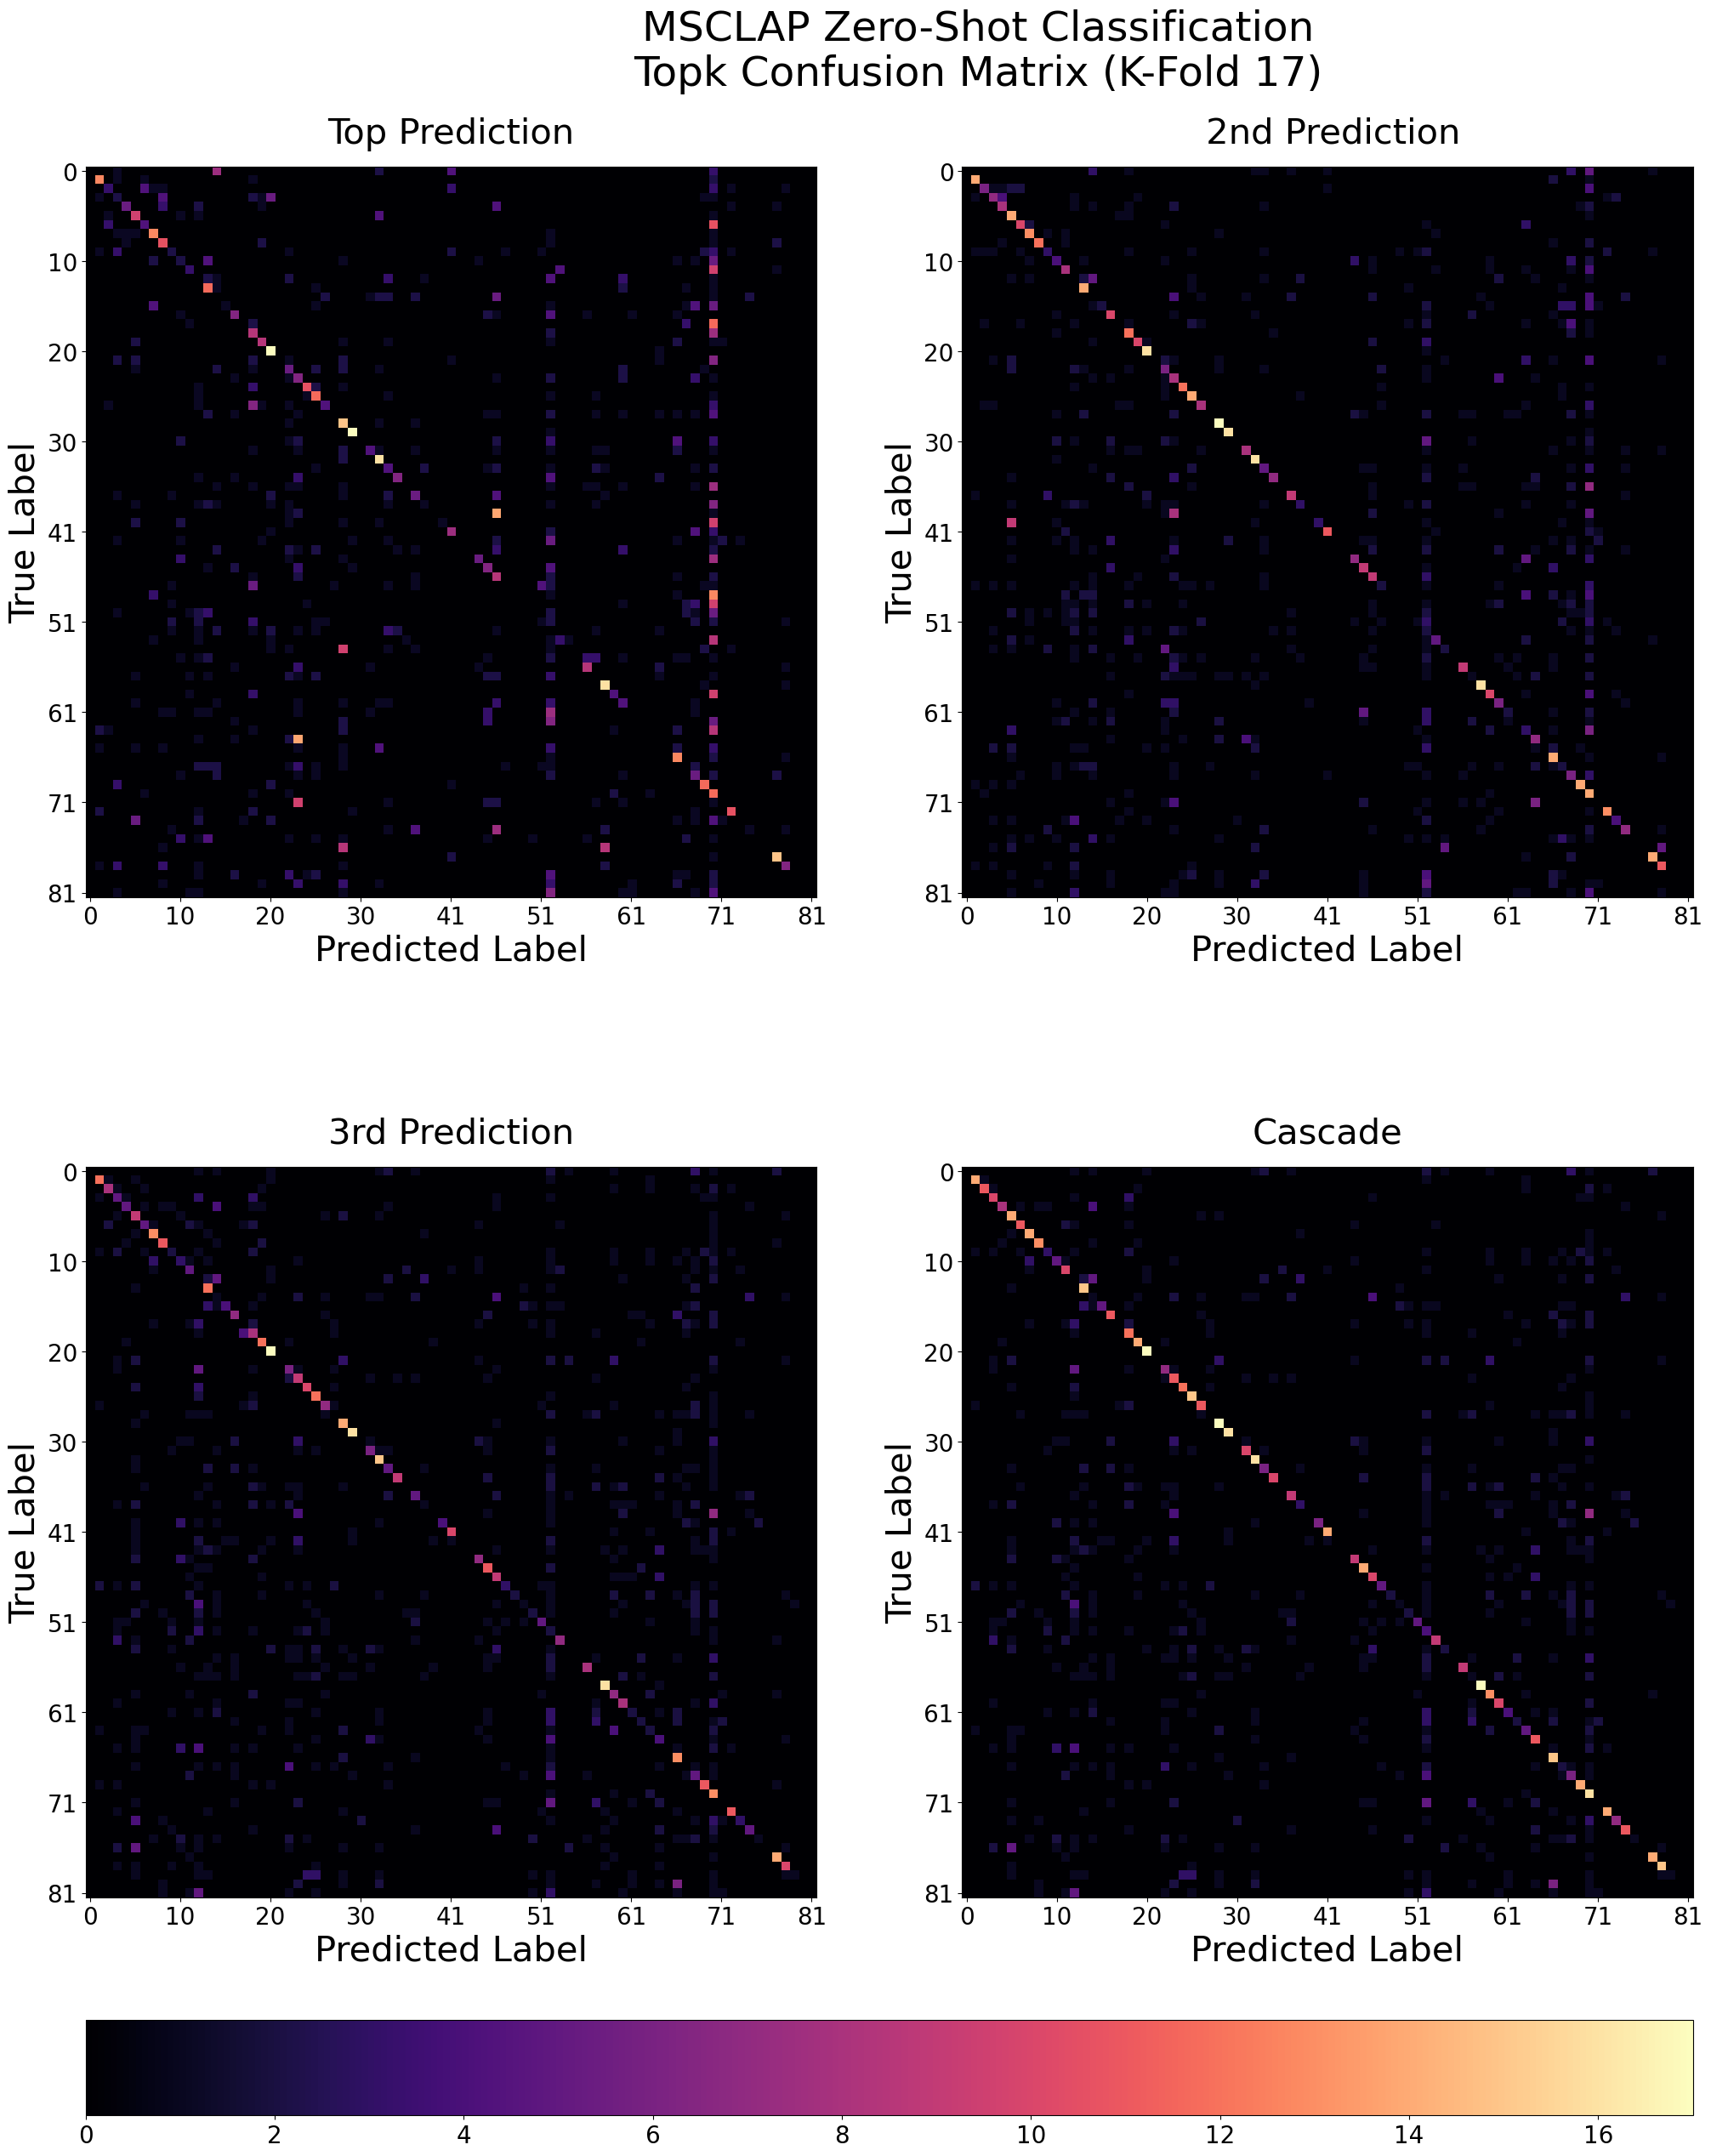

In [35]:
# Explort Confusion Matrix

fig, axes = plt.subplots(2, 2, figsize=(28,28))
fig.suptitle("MSCLAP Zero-Shot Classification\nTopk Confusion Matrix (K-Fold 200)", fontsize=35, y=0.925)
laion_plot_predictions = np.array([[laion_k_fold_200_pred_labels_topk1, laion_k_fold_200_pred_labels_topk2replaced],
                          [laion_k_fold_200_pred_labels_topk3replaced, laion_k_fold_200_pred_labels_topk_cascade]])
msclap_plot_predictions = np.array([[msclap_k_fold_200_pred_labels_topk1, msclap_k_fold_200_pred_labels_topk2replaced],
                          [msclap_k_fold_200_pred_labels_topk3replaced, msclap_k_fold_200_pred_labels_topk_cascade]])

ax_titles = [["Top Prediction", " 2nd Prediction"], ["3rd Prediction", "Cascade"]]

for i, ax in enumerate(axes[0]):
    for j, ax in enumerate(axes[1]):
        cmp = ConfusionMatrixDisplay.from_predictions(msclap_k_fold_200_gold_labels, msclap_plot_predictions[i, j], colorbar=False, include_values=False, cmap='magma', ax=axes[i, j])
        axes[i, j].set_title(f"{ax_titles[i][j]}", fontsize=30, pad=20)
        axes[i, j].set_xlabel("Predicted Label", fontsize=30)
        axes[i, j].set_ylabel("True Label",fontsize=30)
        axes[i, j].set_xticks(np.arange(0,81,10))
        axes[i, j].set_yticks(np.arange(0,81,10))
        axes[i, j].tick_params(axis='both', which='both', labelsize=20)
        axes[i, j].text(x=0.0, y=0.0, s="")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.125, 0.04, 0.675, 0.04])
cbar = fig.colorbar(cmp.im_, cax=cbar_ax, location="bottom")
cbar.ax.tick_params(labelsize=20)

plt.savefig("kfold200_ms_zero_shot_topk.png", dpi=300, bbox_inches='tight', transparent=False)

In [44]:
# Inspect which classes misclassified samples belong to.
with open (settings_kfold200['class_converter'], 'r') as f:
    ucs_classes = json.load (f)

ucs_classes['int_to_class']["35"]

'footsteps'

## Class-Merged kfold17

In [39]:
msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels = k_fold_zs_predict(
    settings_kfold17,
    k_fold_17_audio_embeddings_msclap, 
    msclap_model.get_text_embeddings, 
    msclap_model.compute_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in msclap_k_fold_17_pred_labels] # 1st Prediction
k_2 = [row[1] for row in msclap_k_fold_17_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in msclap_k_fold_17_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
msclap_kfold17_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(msclap_k_fold_17_gold_labels, k_1, k_2)]
msclap_kfold17_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(msclap_k_fold_17_gold_labels, k_1, k_3)]
# Cascading version
msclap_kfold17_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(msclap_k_fold_17_gold_labels, msclap_kfold17_pred_labels_topk2replaced, k_3)]

# Evaluate
msclap_kfold17_accuracy_k2, msclap_kfold17_precision_k2, msclap_kfold17_recall_k2, msclap_kfold17_f1_k2, msclap_kfold17_ap_k2 = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_kfold17_pred_labels_topk2replaced)

print(f"MSCLAP Accuracy Score (Topk=2): {msclap_kfold17_accuracy_k2}")
print(f"MSCLAP Average Precision Score (Topk=2): {msclap_kfold17_ap_k2}")
print(f"MSCLAP Precision Score (Topk=2): {msclap_kfold17_precision_k2}")
print(f"MSCLAP Recall Score (Topk=2): {msclap_kfold17_recall_k2}")
print(f"MSCLAP F1 Score (Topk=2): {msclap_kfold17_f1_k2}")
print("\n")
msclap_kfold17_accuracy_k3, msclap_kfold17_precision_k3, msclap_kfold17_recall_k3, msclap_kfold17_f1_k3, msclap_kfold17_ap_k3 = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_kfold17_pred_labels_topk3replaced)

print(f"MSCLAP Accuracy Score (Topk=3): {msclap_kfold17_accuracy_k3}")
print(f"MSCLAP Average Precision Score (Topk=3): {msclap_kfold17_ap_k3}")
print(f"MSCLAP Precision Score (Topk=3): {msclap_kfold17_precision_k3}")
print(f"MSCLAP Recall Score (Topk=3): {msclap_kfold17_recall_k3}")
print(f"MSCLAP F1 Score (Topk=3): {msclap_kfold17_f1_k3}")
print("\n")
msclap_kfold17_accuracy_cascade, msclap_kfold17_precision_cascade, msclap_kfold17_recall_cascade, msclap_kfold17_f1_cascade, msclap_kfold17_ap_cascade = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_kfold17_pred_labels_topk_cascade)

print(f"MSCLAP Accuracy Score (Topk=2+3): {msclap_kfold17_accuracy_cascade}")
print(f"MSCLAP Average Precision Score (Topk=2+3): {msclap_kfold17_ap_cascade}")
print(f"MSCLAP Precision Score (Topk=2+3): {msclap_kfold17_precision_cascade}")
print(f"MSCLAP Recall Score (Topk=2+3): {msclap_kfold17_recall_cascade}")
print(f"MSCLAP F1 Score (Topk=2+3): {msclap_kfold17_f1_cascade}")

100%|██████████| 17/17 [00:05<00:00,  3.21it/s]

MSCLAP Accuracy Score (Topk=2): 0.36020334059549747
MSCLAP Average Precision Score (Topk=2): 0.023266872715705423
MSCLAP Precision Score (Topk=2): 0.3464800207311418
MSCLAP Recall Score (Topk=2): 0.3602033405954974
MSCLAP F1 Score (Topk=2): 0.3260359363834089


MSCLAP Accuracy Score (Topk=3): 0.3289760348583878
MSCLAP Average Precision Score (Topk=3): 0.022870377696160023
MSCLAP Precision Score (Topk=3): 0.3399327276639201
MSCLAP Recall Score (Topk=3): 0.32897603485838783
MSCLAP F1 Score (Topk=3): 0.30368962925162774


MSCLAP Accuracy Score (Topk=2+3): 0.4371822803195352
MSCLAP Average Precision Score (Topk=2+3): 0.022677281493104377
MSCLAP Precision Score (Topk=2+3): 0.4231959180921179
MSCLAP Recall Score (Topk=2+3): 0.43718228031953515
MSCLAP F1 Score (Topk=2+3): 0.39753408404895807


In [40]:
laion_kfold17_gold_labels, laion_kfold17_pred_labels = k_fold_zs_predict(
    settings_kfold17,
    k_fold_17_audio_embeddings_laion, 
    laion_clap_model.get_text_embedding, 
    torch.cosine_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in laion_kfold17_pred_labels] # 1st Prediction
k_2 = [row[1] for row in laion_kfold17_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in laion_kfold17_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
laion_kfold17_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(laion_kfold17_gold_labels, k_1, k_2)]
laion_kfold17_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(laion_kfold17_gold_labels, k_1, k_3)]
# Cascading version
laion_kfold17_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(laion_kfold17_gold_labels, laion_kfold17_pred_labels_topk2replaced, k_3)]

# Evaluate
laion_kfold17_accuracy_k2, laion_kfold17_precision_k2, laion_kfold17_recall_k2, laion_kfold17_f1_k2, laion_kfold17_ap_k2 = k_fold_zs_evaluation(laion_kfold17_gold_labels, laion_kfold17_pred_labels_topk2replaced)

print(f"LAION CLAP Accuracy Score (Topk=2): {laion_kfold17_accuracy_k2}")
print(f"LAION CLAP Average Precision Score (Topk=2): {laion_kfold17_ap_k2}")
print(f"LAION CLAP Precision Score (Topk=2): {laion_kfold17_precision_k2}")
print(f"LAION CLAP Recall Score (Topk=2): {laion_kfold17_recall_k2}")
print(f"LAION CLAP F1 Score (Topk=2): {laion_kfold17_f1_k2}")
print("\n")
laion_kfold17_accuracy_k3, laion_kfold17_precision_k3, laion_kfold17_recall_k3, laion_kfold17_f1_k3, laion_kfold17_ap_k3 = k_fold_zs_evaluation(laion_kfold17_gold_labels, laion_kfold17_pred_labels_topk3replaced)

print(f"LAION CLAP Accuracy Score (Topk=3): {laion_kfold17_accuracy_k3}")
print(f"LAION CLAP Average Precision Score (Topk=3): {laion_kfold17_ap_k3}")
print(f"LAION CLAP Precision Score (Topk=3): {laion_kfold17_precision_k3}")
print(f"LAION CLAP Recall Score (Topk=3): {laion_kfold17_recall_k3}")
print(f"LAION CLAP F1 Score (Topk=3): {laion_kfold17_f1_k3}")
print("\n")
laion_kfold17_accuracy_cascade, laion_kfold17_precision_cascade, laion_kfold17_recall_cascade, laion_kfold17_f1_cascade, laion_kfold17_ap_cascade = k_fold_zs_evaluation(laion_kfold17_gold_labels, laion_kfold17_pred_labels_topk_cascade)

print(f"LAION CLAP Accuracy Score (Topk=2+3): {laion_kfold17_accuracy_cascade}")
print(f"LAION CLAP Average Precision Score (Topk=2+3): {laion_kfold17_ap_cascade}")
print(f"LAION CLAP Precision Score (Topk=2+3): {laion_kfold17_precision_cascade}")
print(f"LAION CLAP Recall Score (Topk=2+3): {laion_kfold17_recall_cascade}")
print(f"LAION CLAP F1 Score (Topk=2+3): {laion_kfold17_f1_cascade}")

100%|██████████| 17/17 [00:04<00:00,  3.79it/s]

LAION CLAP Accuracy Score (Topk=2): 0.32171387073347857
LAION CLAP Average Precision Score (Topk=2): 0.01107408624028061
LAION CLAP Precision Score (Topk=2): 0.31397288220228387
LAION CLAP Recall Score (Topk=2): 0.3177905308464849
LAION CLAP F1 Score (Topk=2): 0.2908114617473655


LAION CLAP Accuracy Score (Topk=3): 0.28685548293391433
LAION CLAP Average Precision Score (Topk=3): 0.011197076278320318
LAION CLAP Precision Score (Topk=3): 0.30491054887887753
LAION CLAP Recall Score (Topk=3): 0.2833572453371592
LAION CLAP F1 Score (Topk=3): 0.2655490840150719


LAION CLAP Accuracy Score (Topk=2+3): 0.38925199709513436
LAION CLAP Average Precision Score (Topk=2+3): 0.011197173620748558
LAION CLAP Precision Score (Topk=2+3): 0.3844450236764869
LAION CLAP Recall Score (Topk=2+3): 0.3845050215208034
LAION CLAP F1 Score (Topk=2+3): 0.3557153109851266


In [18]:
# Log Results
experiment_logger.experiment_name = "kfold17-zero_shot-topk"
results = {
    "msclap" : {
        "topk1" : {
            "accuracy" : msclap_k_fold_17_accuracy,
            "average_precision" : msclap_k_fold_17_ap,
            "recall" : msclap_k_fold_17_recall,
            "precision" : msclap_k_fold_17_precision,
            "f1" : msclap_k_fold_17_f1
        },
        "topk2" : {
            "accuracy" : msclap_kfold17_accuracy_k2,
            "average_precision" : msclap_kfold17_ap_k2,
            "recall" : msclap_kfold17_recall_k2,
            "precision" : msclap_kfold17_precision_k2,
            "f1" : msclap_kfold17_f1_k2
        },
        "topk3" : {
            "accuracy" : msclap_kfold17_accuracy_k3,
            "average_precision" : msclap_kfold17_ap_k3,
            "recall" : msclap_kfold17_recall_k3,
            "precision" : msclap_kfold17_precision_k3,
            "f1" : msclap_kfold17_f1_k3
        },
        "cascade" : {
            "accuracy" : msclap_kfold17_accuracy_cascade,
            "average_precision" : msclap_kfold17_ap_cascade,
            "recall" : msclap_kfold17_recall_cascade,
            "precision" : msclap_kfold17_precision_cascade,
            "f1" : msclap_kfold17_f1_cascade
        },
    },
    "laion" : {
        "topk1" : {
            "accuracy" : laion_k_fold_17_accuracy,
            "average_precision" : laion_k_fold_17_ap,
            "recall" : laion_k_fold_17_recall,
            "precision" : laion_k_fold_17_precision,
            "f1" : laion_k_fold_17_f1
        },
        "topk2" : {
            "accuracy" : laion_kfold17_accuracy_k2,
            "average_precision" : laion_kfold17_ap_k2,
            "recall" : laion_kfold17_recall_k2,
            "precision" : laion_kfold17_precision_k2,
            "f1" : laion_kfold17_f1_k2
        },
        "topk3" : {
            "accuracy" : laion_kfold17_accuracy_k3,
            "average_precision" : laion_kfold17_ap_k3,
            "recall" : laion_kfold17_recall_k3,
            "precision" : laion_kfold17_precision_k3,
            "f1" : laion_kfold17_f1_k3
        },
        "cascade" : {
            "accuracy" : laion_kfold17_accuracy_cascade,
            "average_precision" : laion_kfold17_ap_cascade,
            "recall" : laion_kfold17_recall_cascade,
            "precision" : laion_kfold17_precision_cascade,
            "f1" : laion_kfold17_f1_cascade
        }
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

In [41]:
# Prepare top predictions for plotting. Unpack.
laion_kfold17_pred_labels_topk1 = [row[0] for row in laion_kfold17_pred_labels] # 1st Prediction
msclap_kfold17_pred_labels_topk1 = [row[0] for row in msclap_k_fold_17_pred_labels] # 1st Prediction

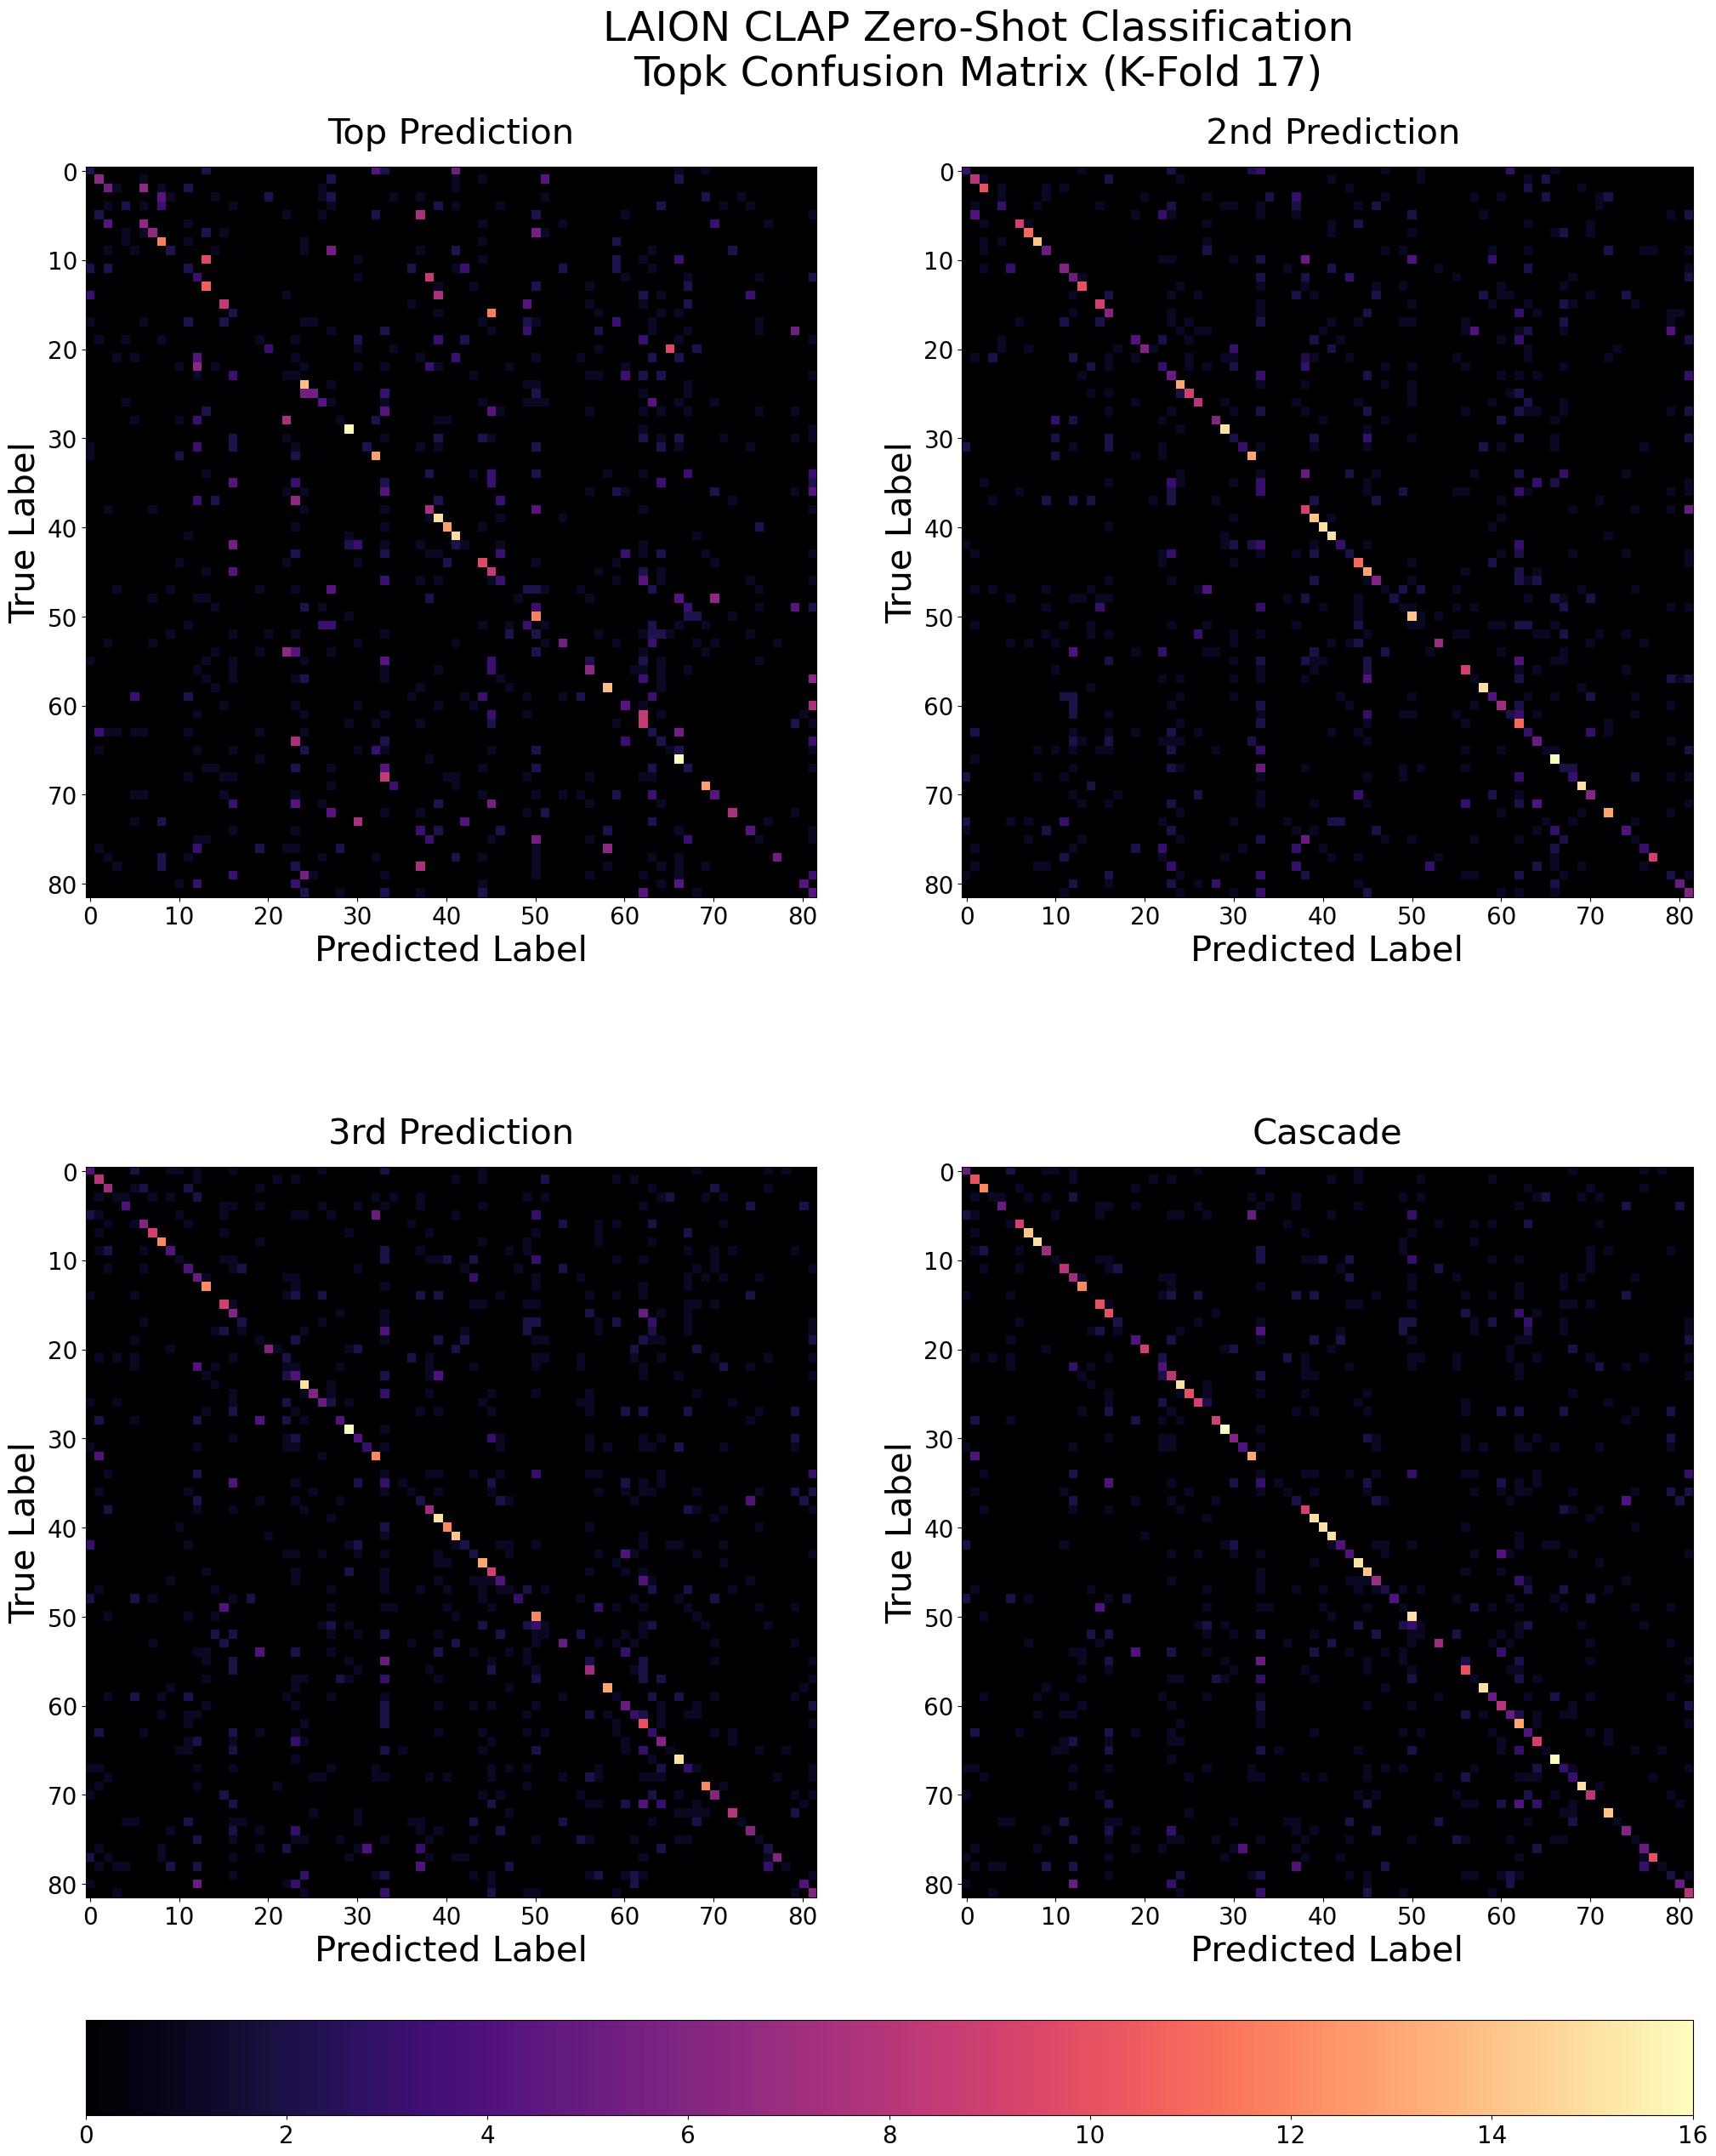

In [45]:
# Explort Confusion Matrix

fig, axes = plt.subplots(2, 2, figsize=(28,28))
fig.suptitle("LAION CLAP Zero-Shot Classification\nTopk Confusion Matrix (K-Fold 17)", fontsize=35, y=0.925)
laion_plot_predictions = np.array([[laion_kfold17_pred_labels_topk1, laion_kfold17_pred_labels_topk2replaced],
                          [laion_kfold17_pred_labels_topk3replaced, laion_kfold17_pred_labels_topk_cascade]])
msclap_plot_predictions = np.array([[msclap_kfold17_pred_labels_topk1, msclap_kfold17_pred_labels_topk2replaced],
                          [msclap_kfold17_pred_labels_topk3replaced, msclap_kfold17_pred_labels_topk_cascade]])

ax_titles = [["Top Prediction", " 2nd Prediction"], ["3rd Prediction", "Cascade"]]

for i, ax in enumerate(axes[0]):
    for j, ax in enumerate(axes[1]):
        cmp = ConfusionMatrixDisplay.from_predictions(laion_k_fold_17_gold_labels, laion_plot_predictions[i, j], colorbar=False, include_values=False, cmap='magma', ax=axes[i, j])
        axes[i, j].set_title(f"{ax_titles[i][j]}", fontsize=30, pad=20)
        axes[i, j].set_xlabel("Predicted Label", fontsize=30)
        axes[i, j].set_ylabel("True Label",fontsize=30)
        axes[i, j].set_xticks(np.arange(0,81,10))
        axes[i, j].set_yticks(np.arange(0,81,10))
        axes[i, j].tick_params(axis='both', which='both', labelsize=20)
        axes[i, j].text(x=0.0, y=0.0, s="")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.125, 0.04, 0.675, 0.04])
cbar = fig.colorbar(cmp.im_, cax=cbar_ax, location="bottom")
cbar.ax.tick_params(labelsize=20)

plt.savefig("kfold17_laion_zero_shot_topk.png", dpi=300, bbox_inches='tight', transparent=False)